# VASICEK MODEL

The Vasicek model is described by the following stochastic differential equation:

$$
dr_t = a(b - r_t)dt + \sigma dW_t
$$

Where:
- $r_t$ is the short-term interest rate at time $t$.
- $a, b,$ and $\sigma$ are parameters of the model:
    - $a > 0$ is the speed of reversion.
    - $b$ is the long-term mean level.
    - $\sigma > 0$ is the instantaneous volatility.
- $dW_t$ represents the Wiener process (or Brownian motion).



Its key features are the following:

**1. Mean Reversion:** The term $a(b - r_t)$ drives the rate $r_t$ towards the long-term mean $b$ with speed $a$. This reflects the empirical observation that interest rates tend to revert to an average level over time.

**2. Normal Distribution:** The solution to the Vasicek model yields normally distributed rates, which is a simplification and can be a drawback as it allows for negative interest rates, which may not be realistic in all financial contexts.

**3. Analytical Tractability:** One of the strengths of the Vasicek model is that it allows for an analytical solution for bond prices, which is not possible in many other models of interest rates.



# Libraries

In [ ]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.linear_model import LinearRegression

# Simulation Vasicek Process with Euler-Maruyama Discretisation


To simulate the interest rate path over time, one typically employs the Euler-Maruyama method to discretize the stochastic differential equation. The discrete-time version of the Vasicek model can be written as:

$ r_{t+\Delta t} = r_t + a(b - r_t)\Delta t + \sigma \sqrt{\Delta t} Z_t $

In [ ]:
def vasicek(r0, a, b, sigma, T, num_steps, num_paths):
    dt = T / num_steps
    rates = np.zeros((num_steps + 1, num_paths))
    rates[0] = r0

    for t in range(1, num_steps + 1):
        dW = np.random.normal(0, 1, num_paths)
        rates[t] = rates[t - 1] + a * (b - rates[t - 1]) * dt + sigma * np.sqrt(dt) * dW

    return rates

In [ ]:
# Model parameters
r0 = 0.02  # Initial short rate
a = 0.5    # Mean reversion speed
b = 0.03  # Long-term mean
sigma = 0.01   # Volatility
T = 10      # Time horizon
num_steps = 252  # Number of steps
num_paths = 20   # Number of paths


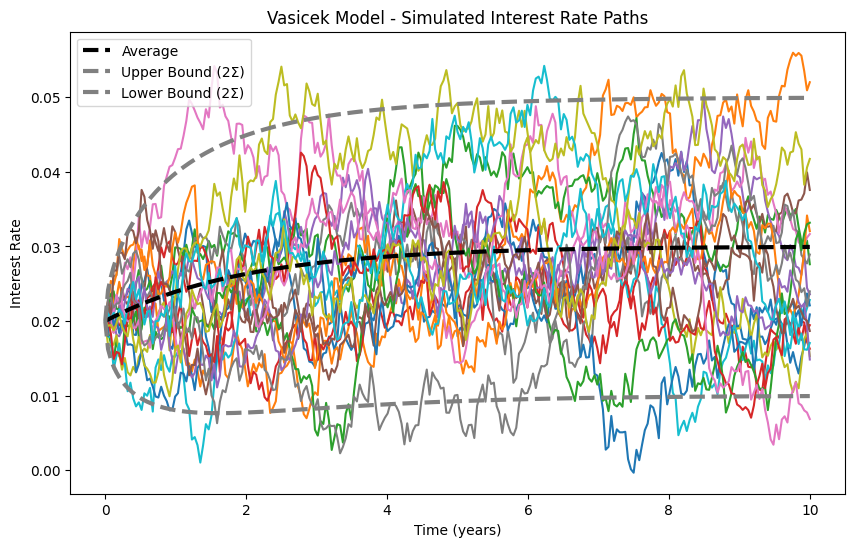

In [ ]:

# Simulate Vasicek model
simulated_rates = vasicek(r0, a, b, sigma, T, num_steps, num_paths)

time_axis = np.linspace(0, T, num_steps + 1)
average_rates = [r0 * np.exp(-a * t) + b * (1 - np.exp(-a * t)) for t in time_axis]
std_dev = [(sigma**2 / (2 * a) * (1 - np.exp(-2 * a * t)))**.5 for t in time_axis]
upper_bound = [average_rates[i] + 2 * std_dev[i] for i in range(len(time_axis))]
lower_bound = [average_rates[i] - 2 * std_dev[i] for i in range(len(time_axis))]

# Plotting multiple paths with time on x-axis
plt.figure(figsize=(10, 6))
plt.title('Vasicek Model - Simulated Interest Rate Paths')
plt.xlabel('Time (years)')
plt.ylabel('Interest Rate')
for i in range(num_paths):
    plt.plot(time_axis, simulated_rates[:, i])

plt.plot(time_axis, average_rates, color='black',linestyle='--', label ='Average', linewidth = 3)
plt.plot(time_axis, upper_bound, color='grey', linestyle='--', label='Upper Bound (2Σ)', linewidth = 3)
plt.plot(time_axis, lower_bound, color='grey', linestyle='--', label='Lower Bound (2Σ)', linewidth = 3)
plt.legend()
plt.show()

# Real Parameters


In [ ]:
# Model parameters we want to estimate
a = .5   # Mean reversion speed
b = 0.03  # Long-term mean
sigma = 0.01   # Volatility

# Simulation One path

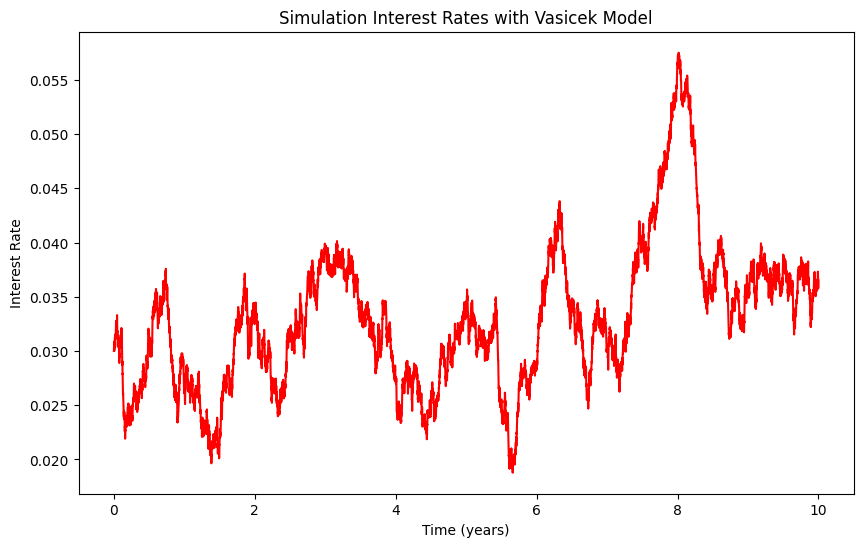

In [ ]:
r0 = 0.03  # Initial short rate
T = 10     # Time horizon
num_steps = 10000  # Number of steps
num_paths = 1   # Number of paths

# Simulate Vasicek model
simulated_rates = vasicek(r0, a, b, sigma, T, num_steps, num_paths)

# Time axis
time_axis = np.linspace(0, T, num_steps + 1)

# Plotting multiple paths with time on x-axis
plt.figure(figsize=(10, 6))
plt.title('Simulation Interest Rates with Vasicek Model')
plt.xlabel('Time (years)')
plt.ylabel('Interest Rate')
for i in range(num_paths):
    plt.plot(time_axis, simulated_rates[:, i], color='red')

plt.show()


# Least Squares

In [ ]:
def Vasicek_LS(r, dt):

    #Linear Regression
    r0 = r[:-1,]
    r1 = r[1:, 0]
    reg = LinearRegression().fit(r0, r1)

    #estimation a and b
    a_LS = (1 - reg.coef_) / dt
    b_LS = reg.intercept_ / (1 - a_LS)

    #estimation sigma
    epsilon = r[1:, 0] - r[:-1,0] * reg.coef_
    sigma_LS = np.std(epsilon) / dt**.5

    return a_LS[0], b_LS[0], sigma_LS

In [ ]:
LS_Estimate = Vasicek_LS(simulated_rates, T / num_steps)
print("a_est: " + str(np.round(LS_Estimate[0],3)))
print("b_est: " + str(np.round(LS_Estimate[1],3)))
print("sigma_est: " + str(np.round(LS_Estimate[2],3)))

a_est: 1.108
b_est: -0.0
sigma_est: 0.01


# Maximum Likelihood Estimation

In [ ]:
def Vasicek_MLE(r, dt):
    r = r[:, 0]
    n = len(r)
    #estimation a and b
    S0 = 0
    S1 = 0
    S00 = 0
    S01 = 0
    for i in range(n-1):
        S0 = S0 + r[i]
        S1 = S1 + r[i + 1]
        S00 = S00 + r[i] * r[i]
        S01 = S01 + r[i] * r[i + 1]
    S0 = S0 / (n-1)
    S1 = S1 / (n-1)
    S00 = S00 / (n-1)
    S01 = S01 / (n-1)
    b_MLE = (S1 * S00 - S0 * S01) / (S0 * S1 - S0**2 - S01 + S00)
    a_MLE = 1 / dt * np.log((S0 - b_MLE) / (S1 - b_MLE))

    #estimation sigma
    beta = 1 / a * (1 - np.exp(-a * dt))
    temp = 0
    for i in range(n-1):
        mi = b * a * beta + r[i] * (1 - a * beta)
        temp = temp + (r[i+1] - mi)**2
    sigma_MLE = (1 / ((n - 1) * beta * (1 - .5 * a * beta)) * temp)**.5
    return a_MLE, b_MLE, sigma_MLE

In [ ]:
MLE_Estimate = Vasicek_MLE(simulated_rates, T / num_steps)
print("a_est: " + str(np.round(MLE_Estimate[0],3)))
print("b_est: " + str(np.round(MLE_Estimate[1],3)))
print("sigma_est: " + str(np.round(MLE_Estimate[2],3)))

a_est: 0.031
b_est: 0.033
sigma_est: 0.005


# Accuracy Estimates


# Exercise :

With Real Data :
- get rates data on yahoo finance : '^TNX'  for 10y treasury rate.
- Perform the regression to get calibrated parameters.
- Simulate paths with parameters.



The discretisation equation is :

$ r_{t+\Delta t} = r_t + a(b - r_t)\Delta t + \sigma \sqrt{\Delta t} Z_t $

Which can be rearranged as :

$ r_{t+\Delta t} - r_t =  (1-a\Delta t)\cdot r_t + a\cdot b \cdot \Delta t + \sigma \sqrt{\Delta t} \varepsilon $

$ r_{t+\Delta t} - r_t =  \alpha \cdot r_t + \beta + \xi $

with $\xi$ iid normally distributed.

$(\hat{\alpha}, \hat{\beta})$ estimated by least squares method (regression of $r_{t+\Delta t}$ on $r_t$.

Then,
$(\hat{a}, \hat{b}) = \left( \frac{1-\hat{\alpha}}{\Delta t}, \frac{\hat{\beta}}{1-\hat{\alpha}}\right)$
and,
$\sigma^2 = \sqrt{\frac{Var(\xi)}{\Delta t}}$





In [ ]:
import yfinance as yf

# Define the ticker symbol for the stock you're interested in
ticker_symbol = '^TNX'

# Retrieve the data
data = yf.download(ticker_symbol)

# Display the first few rows of the retrieved data
data.head()


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1962-01-02,4.06,4.06,4.06,4.06,4.06,0
1962-01-03,4.03,4.03,4.03,4.03,4.03,0
1962-01-04,3.99,3.99,3.99,3.99,3.99,0
1962-01-05,4.02,4.02,4.02,4.02,4.02,0
1962-01-08,4.03,4.03,4.03,4.03,4.03,0


In [ ]:
data = data["Adj Close"]["2000":]
data

Date
2000-01-03    6.548
2000-01-04    6.485
2000-01-05    6.599
2000-01-06    6.549
2000-01-07    6.504
              ...  
2024-02-05    4.164
2024-02-06    4.090
2024-02-07    4.110
2024-02-08    4.170
2024-02-09    4.187
Name: Adj Close, Length: 6058, dtype: float64

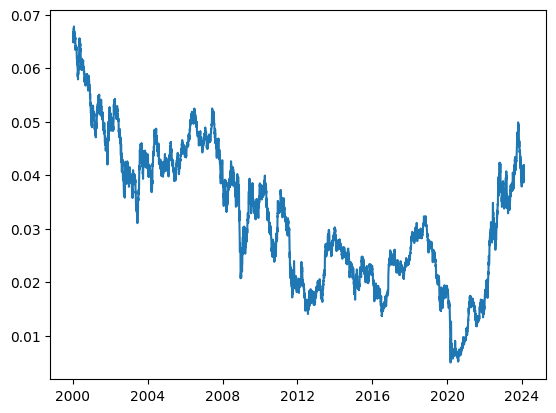

In [ ]:
plt.plot(data/100)
plt.show()

# Now you have parameters, please generate paths with montecarlo simulations

## here are the formulas : $ r_{t+\Delta t} = r_t + a(b - r_t)\Delta t + \sigma \sqrt{\Delta t} Z_t $

 # Price of a ZCB with Vasicek

 For zero-coupon bonds, the Vasicek model provides a closed-form solution for bond prices. The formula for a zero-coupon bond price is:

$$
P(t, T) = e^{\left( A(t, T) - B(t, T) r_t \right)}
$$

Where:
- $P(t, T)$ is the price at time $t$ of a zero-coupon bond maturing at time $T$,
- $A(t, T)$ and $B(t, T)$ are functions of the model parameters and time, given by:
  $$ A(t, T) = \left[ \left( b - \frac{\sigma^2}{2a^2} \right) (B(t, T) - (T - t)) - \frac{\sigma^2 B^2(t, T)}{4a} \right] $$
  $$ B(t, T) = \frac{1 - e^{-a(T-t)}}{a} $$


In [ ]:
import numpy as np

def vasicek_zero_coupon_bond_price(r_t, T, t, a, b, sigma):
    """
    Calculate the price of a zero-coupon bond under the Vasicek model.

    Parameters:
    - r_t: The current short-term interest rate.
    - T: The maturity time of the bond.
    - t: The current time.
    - a: The speed of mean reversion.
    - b: The long-term mean interest rate.
    - sigma: The volatility of the interest rate.

    Returns:
    - The price of the zero-coupon bond.
    """
    # Calculate B(t, T)
    B = (1 - np.exp(-a * (T - t))) / a

    # Calculate A(t, T)
    A = ((b - (sigma**2) / (2 * a**2)) * (B - (T - t)) - (sigma**2) * B**2 / (4 * a))

    # Calculate the bond price
    bond_price = np.exp(A - B * r_t)

    return bond_price



In [ ]:
a = kappa     # Speed of mean reversion
b = theta   # Long-term mean interest rate
sigma_ = sigma  # Volatility of the interest rate
r_t = rates[-1]   # Current short-term interest rate
T = 5       # Maturity of the bond in years
t = 0       # Current time

price = vasicek_zero_coupon_bond_price(r_t, T, t, a, b, sigma_)
print(f"The price of the zero-coupon bond is: {round(price*100,2)}%")

The price of the zero-coupon bond is: 85.25%
